In [2]:
# Required modules
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import IPython
import sklearn
import graphviz
# import mglearn
import sys

print("Python Version: {}".format(sys.version))
print("Pandas Version: {}".format(pd.__version__))
print("matplotlib Version: {}".format(matplotlib.__version__))
print("NumPy Version: {}".format(np.__version__))
print("SciPy Version: {}".format(sp.__version__))
print("IPython Version: {}".format(IPython.__version__))
print("Scikit-learn Version: {}".format(sklearn.__version__))
print("graphviz Version: {}".format(graphviz.__version__))
# print("Mglearn Version: {}".format(mglearn.__version__))

Python Version: 3.6.2 | packaged by conda-forge | (default, Jul 23 2017, 22:59:30) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
Pandas Version: 0.20.3
matplotlib Version: 2.0.2
NumPy Version: 1.13.1
SciPy Version: 0.19.1
IPython Version: 6.1.0
Scikit-learn Version: 0.18.2
graphviz Version: 0.5.2


In [3]:
# using magic matplotlib to avoid plotting in a separate window
%matplotlib inline

In [4]:
# Constant parameters given by the DySpan PU setup                              
DELAY_1 = 0.005 # tau1                                                          
DELAY_2 = 0.01  # tau2                                                          
TCONST = 0.002                                                                  
MEAN1 = 0.02    # lambda1                                                       
MEAN2 = 0.01    # lambda2                                                       
MEAN3 = 0.005   # lambda3 
N_CHAN = 4      # Number of channels
N_SCN = 10      # Number of scenarios
N_SAMPS = 4000  # Number of samples in the dataset per scenario
NUM_SLICES = 10 # Number of different dataset sizes
CLASS_NAMES = ["Scenario_{}".format(i) for i in range(10)]
FEATURE_NAMES = ["IF delay ch 1", 
                 "IF delay ch 2", 
                 "IF delay ch 3",
                 "IF delay ch 4",
                 "Packet Rate",
                 "IF variance"]

In [5]:
# Create iterables for packet rate and variance
if_time_scn_ch = [[[channel] for channel in range(N_CHAN)] 
                  for scenario in range(N_SCN)]
packet_rate_scn = [[] for scenario in range(N_SCN)]
variance_scn = [[] for scenario in range(N_SCN)]

for scenario in range(N_SCN):
    for channel in range(N_CHAN):
        if_time_scn_ch[scenario][channel] = sp.fromfile(open(
            "../../data/feature_extraction/2/interframe_time_ch_{}_scn_{}.dat"
            .format(channel+1, scenario)), dtype=sp.float32)
    packet_rate_scn[scenario] = sp.fromfile(open("../../data/feature_extraction/2/packet_rate_scn_{}.dat".format(scenario)),
                                                dtype=sp.float32)
    variance_scn[scenario] = sp.fromfile(open("../../data/feature_extraction/2/variance_scn_{}.dat".format(scenario)),
                                             dtype=sp.float32)

In [6]:
# Generate a vector that includes the interframe time for all channels
if_vector = [[] for i in range(N_SAMPS*N_SCN)]
for scn in range(N_SCN):
    for i in range(N_SAMPS):
        for chan in range(N_CHAN):
            if_vector[i + N_SAMPS*scn].append(if_time_scn_ch[scn][chan][i])

In [7]:
# Generate label vector
labels = [i for i in range(N_SCN) for n in range(N_SAMPS)]

In [8]:
# https://stackoverflow.com/questions/17485747/how-to-convert-a-nested-list-into-a-one-dimensional-list-in-python
from collections import Iterable
def flatten(lis):
     for item in lis:
         if isinstance(item, Iterable) and not isinstance(item, str):
             for x in flatten(item):
                 yield x
         else:        
             yield item

In [9]:
# Generate data list that includes all data in a list per frames
data_nested = []
# first generate a long list that includes the packet_rates one scenario
# after the other, and the same for the variances
# packet_rate = [scn0, scn1, ..., scn9]
# len(packet_rate) = N_SAMPS * N_SCN
packet_rate = []
variance = []
for scn in range(N_SCN):
    for i in range(N_SAMPS):
            packet_rate.append(packet_rate_scn[scn][i])
            variance.append(variance_scn[scn][i])

data_nested = list(zip(if_vector, packet_rate, variance))
# Until this point 'data' is a nested list. It needs to be flattened 
# to use it with sci-kit
# TODO: just don't generate it nested and save this method...
data = [[] for i in range(len(data_nested))]
for i in range(len(data_nested)):
    data[i] = list(flatten(data_nested[i]))

In [10]:
# Imports
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [11]:
# Now the data is ready to start applying sci-kit algorithms
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, random_state=0, test_size=0.8)

In [12]:
X_train, X_test, y_train, y_test =  [[[] for _ in range(NUM_SLICES)] for _ in range(4)]
n_points = len(data)

data_train, data_test, labels_train, labels_test = train_test_split(data, 
                                                                    labels, 
                                                                    random_state=42) 
labels_test = [random.randint(0,9) for _ in range(len(labels_test))]
for n in range(NUM_SLICES, 0, -1):
    X_train[NUM_SLICES-n] = data_train[:int(len(data_train)/n)]
    X_test[NUM_SLICES-n] = data_test[:int(len(data_test)/n)]
    y_train[NUM_SLICES-n] = labels_train[:int(len(labels_train)/n)]
    
    y_test[NUM_SLICES-n] = labels_test[:int(len(labels_test)/n)] 

In [15]:
print(len(X_train[0][0]))

6


In [ ]:
# We start with the KNeighbors Classifier
# Generate the model
knn = KNeighborsClassifier(n_neighbors=2)
# Train the model
knn.fit(X_train, y_train)
# Make predictions based on the test data
prediction = knn.predict(X_test)

In [ ]:
# Check the model accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, prediction))

In [12]:
# testing training in a loop
knn_list = [[] for _ in range(NUM_SLICES)]
predictions = [[] for _ in range(NUM_SLICES)]
accs = [[] for _ in range(NUM_SLICES)]
n_neighbors = [2, 4, 10, 50]

for i in range(NUM_SLICES):
    for n in range(len(n_neighbors)):
        knn_list[i].append(KNeighborsClassifier(n_neighbors=n_neighbors[n]))
        knn_list[i][n].fit(X_train[i], y_train[i])
        predictions[i].append(knn_list[i][n].predict(X_test[i]))
        accs[i].append(accuracy_score(y_test[i], predictions[i][n]))

for line in accs:
    print(line)

[0.107, 0.107, 0.107, 0.107]
[0.10531053105310531, 0.10531053105310531, 0.10531053105310531, 0.10531053105310531]
[0.104, 0.104, 0.104, 0.104]
[0.10224089635854341, 0.10224089635854341, 0.10224089635854341, 0.10224089635854341]
[0.1014405762304922, 0.1014405762304922, 0.1014405762304922, 0.10204081632653061]
[0.099500000000000005, 0.099500000000000005, 0.099500000000000005, 0.099000000000000005]
[0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.1004]
[0.098709870987098713, 0.099009900990099015, 0.099009900990099015, 0.099309930993099316]
[0.098000000000000004, 0.098199999999999996, 0.098400000000000001, 0.098199999999999996]
[0.097100000000000006, 0.097199999999999995, 0.097299999999999998, 0.0974]


In [ ]:
# Setting up confusion Matrix for knn
from sklearn.metrics import confusion_matrix
# Confusion Matrix without normalization
confusion_matrix(y_test, prediction)

In [14]:
# Modified version of the script from confusion matrix documentation:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          verbose=False,
                          cmap=plt.cm.Blues):
    """
    Prints and plots the confusion matrix.
    Normalization can be applied with 'normalize=True'
    """
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if verbose:
            print("Normalized confusion matrix")
        else:
            print("Confusion matrix, without normalization")
    if verbose:
        print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.xlabel('True label')
    plt.ylabel('Predicted label')

In [ ]:
# Compute confusion matrix for knn
cnf_matrix_knn = confusion_matrix(y_test, prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix_knn, classes=CLASS_NAMES, verbose=False,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix_knn, classes=CLASS_NAMES, normalize=True,
                      verbose=False,
                      title='Confusion matrix, normalized')
plt.show()

/home/cuervo/anaconda3/envs/thesis/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


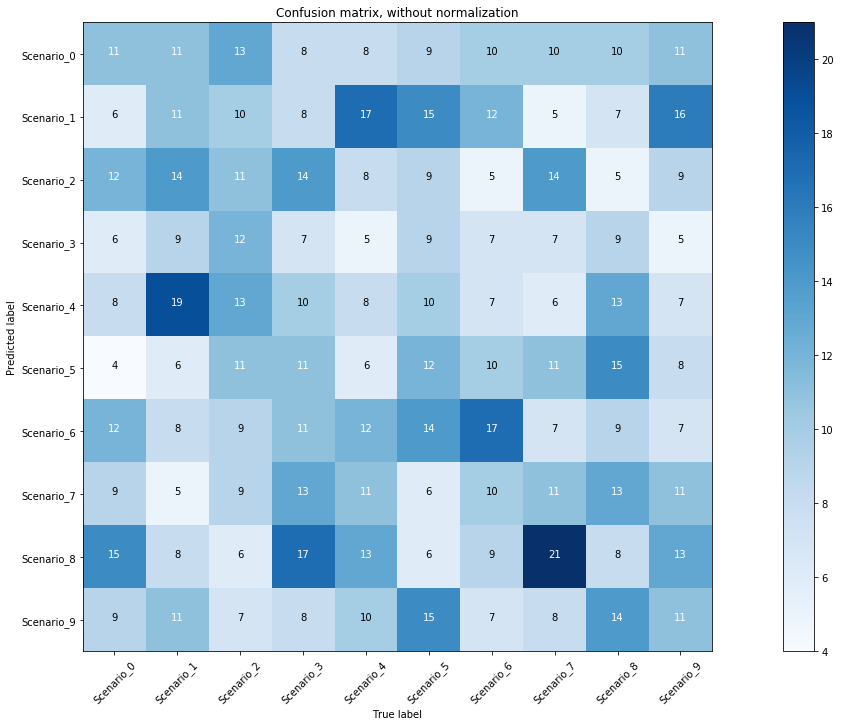

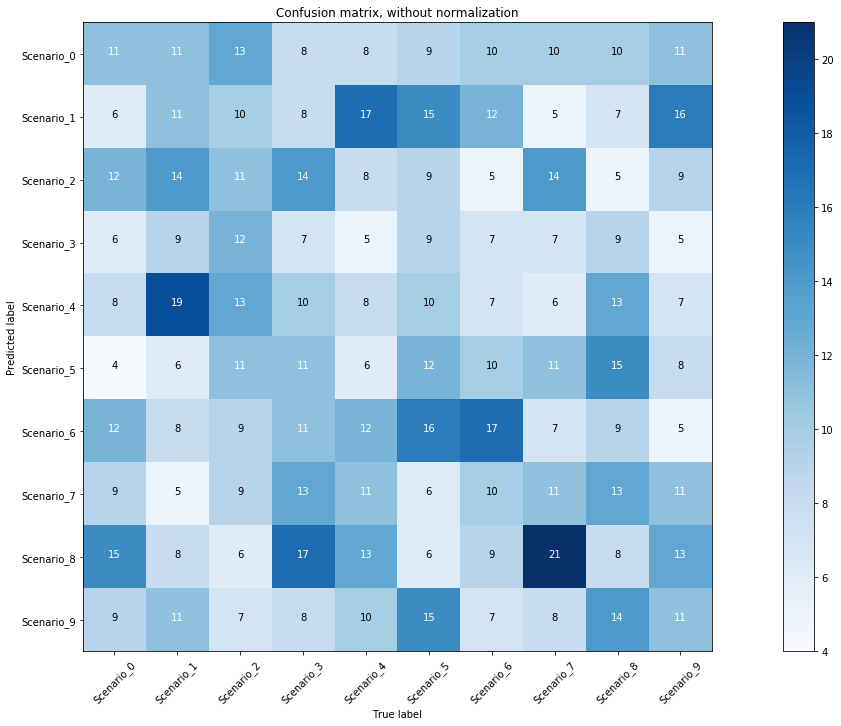

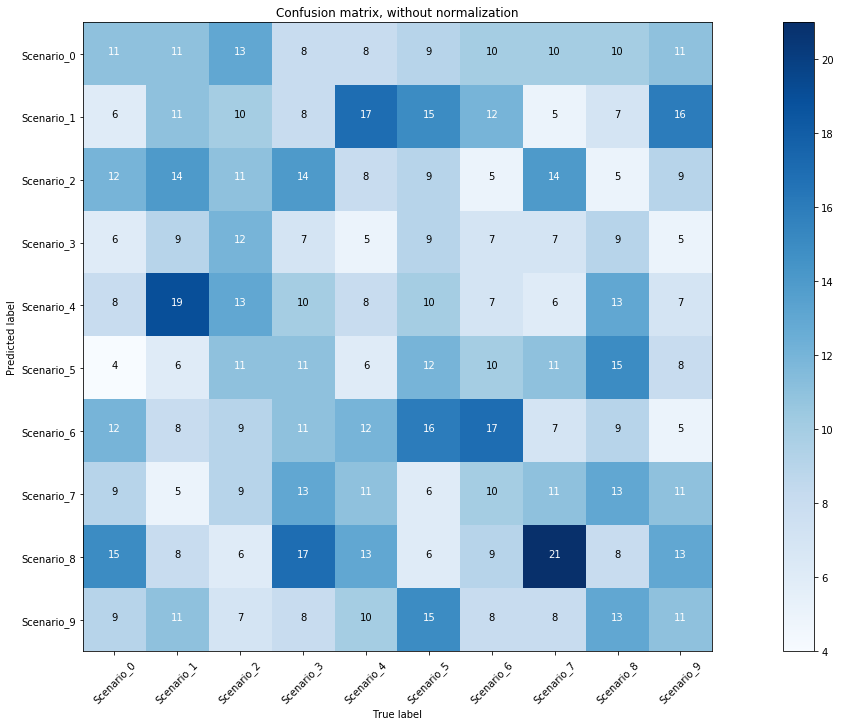

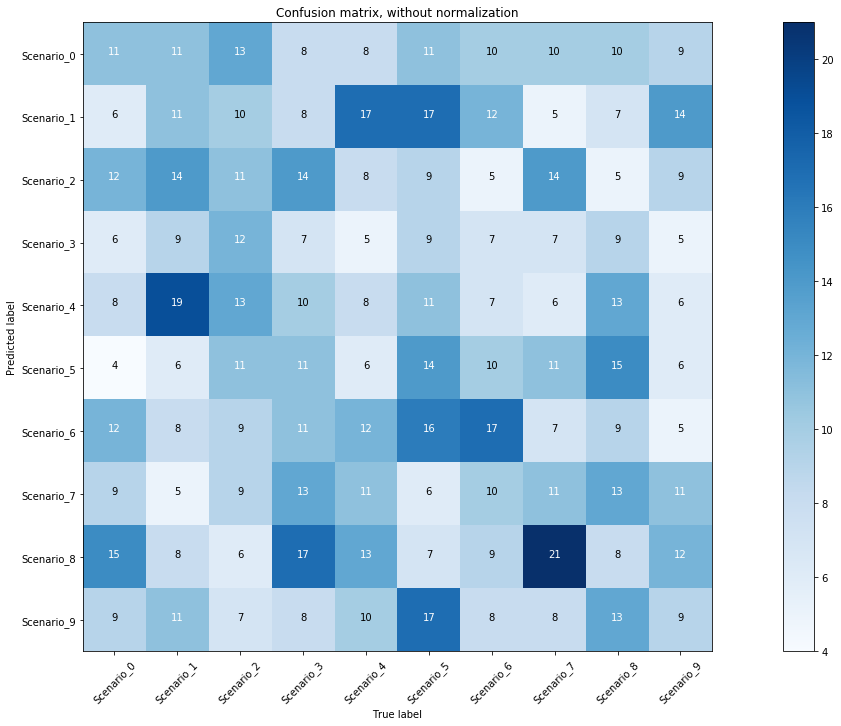

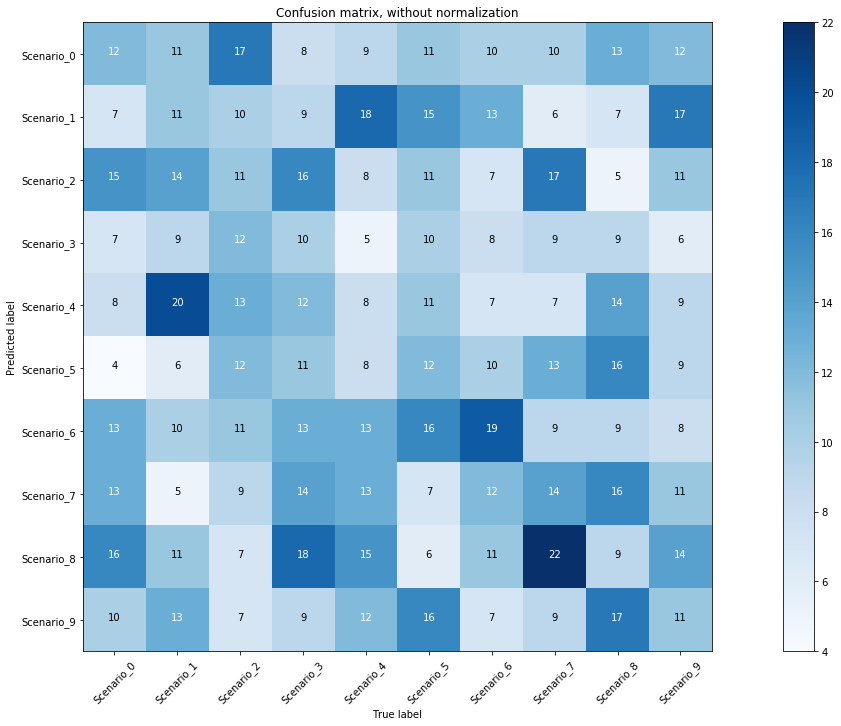

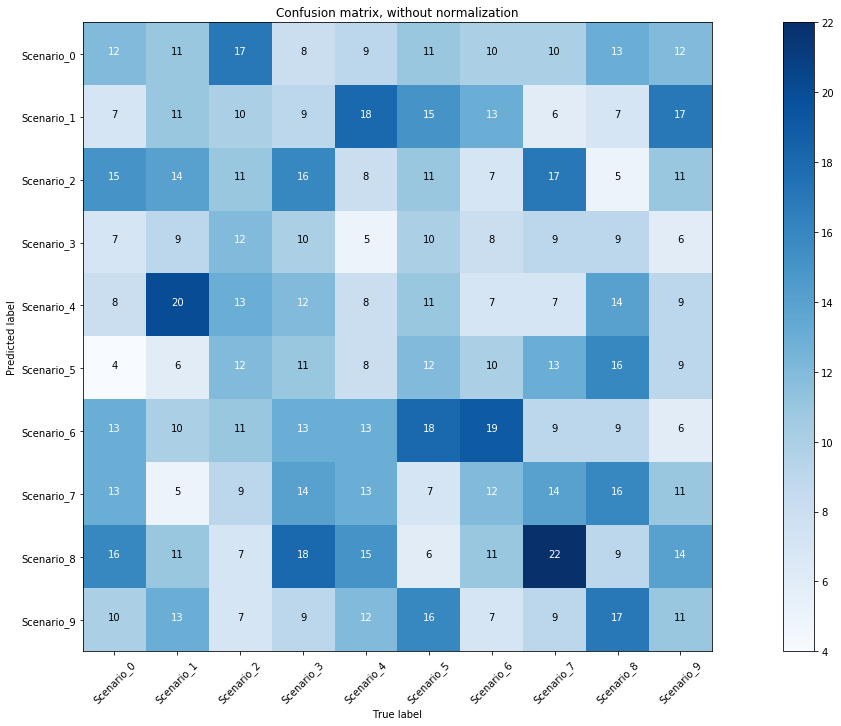

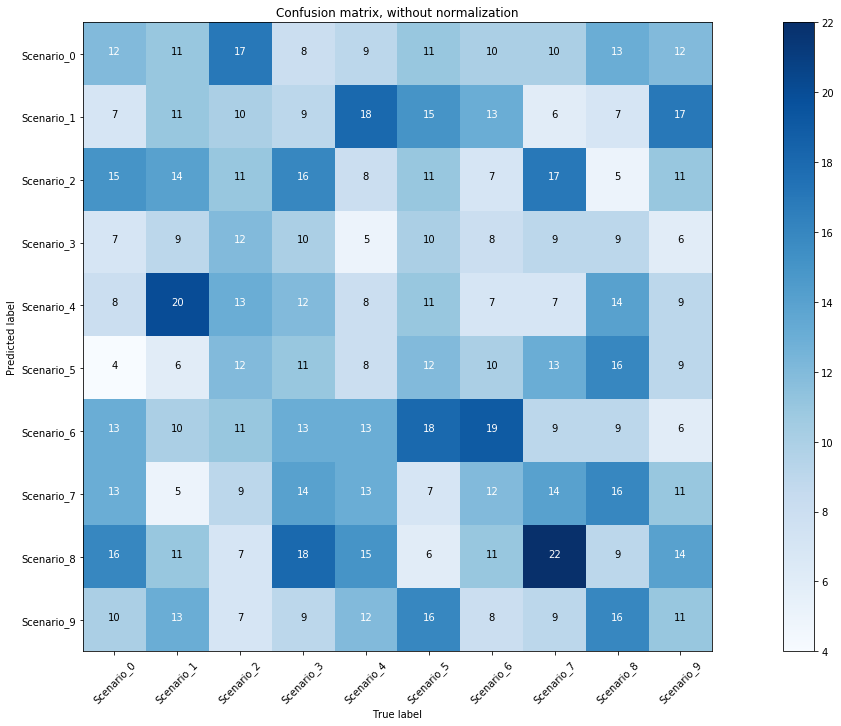

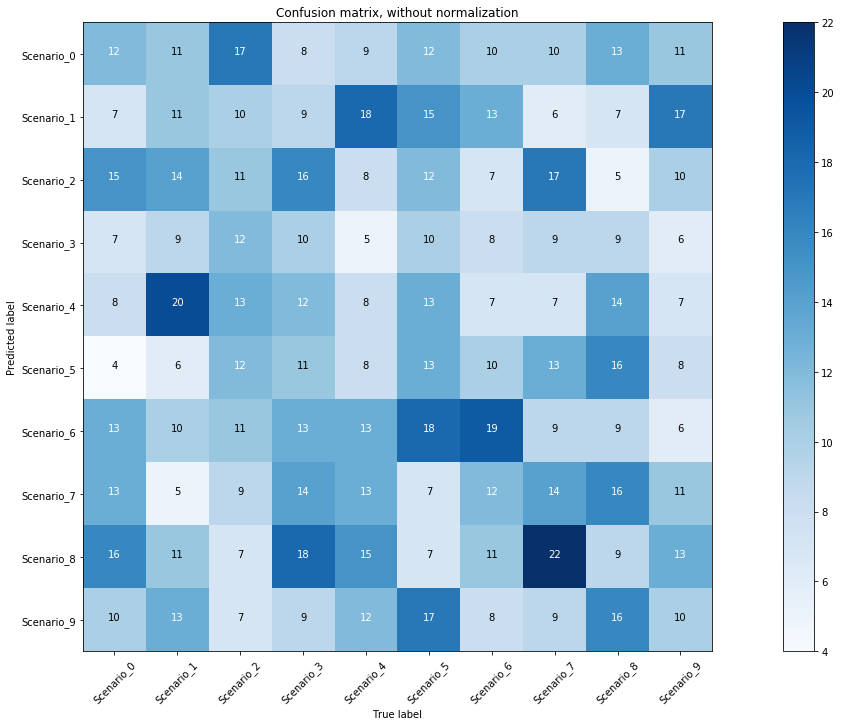

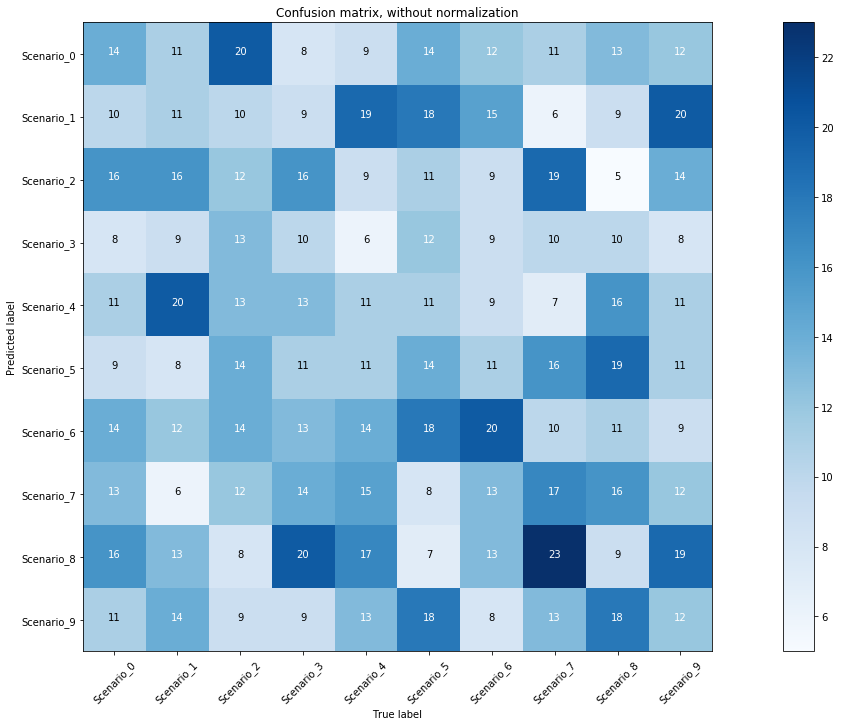

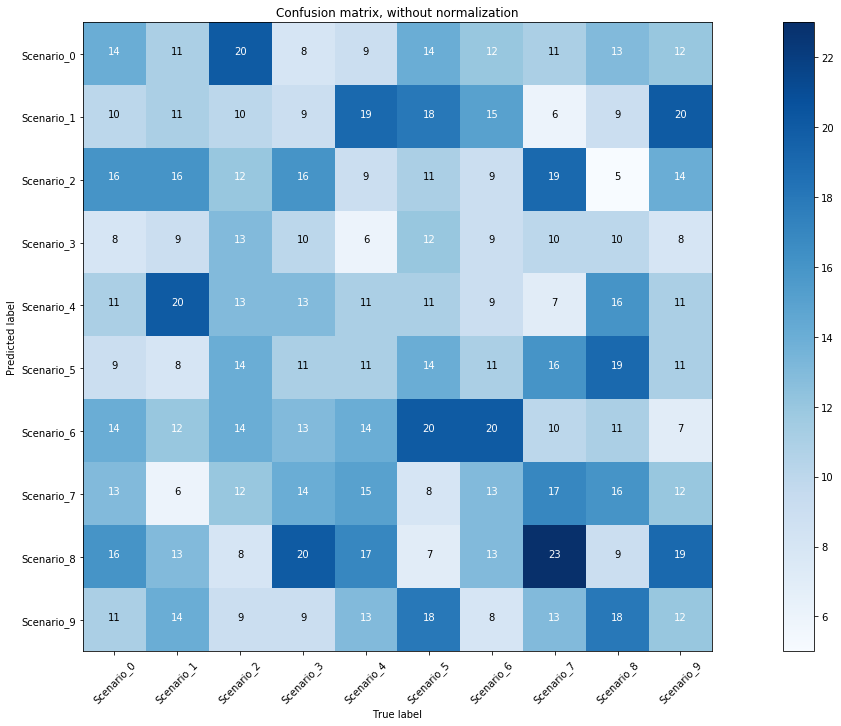

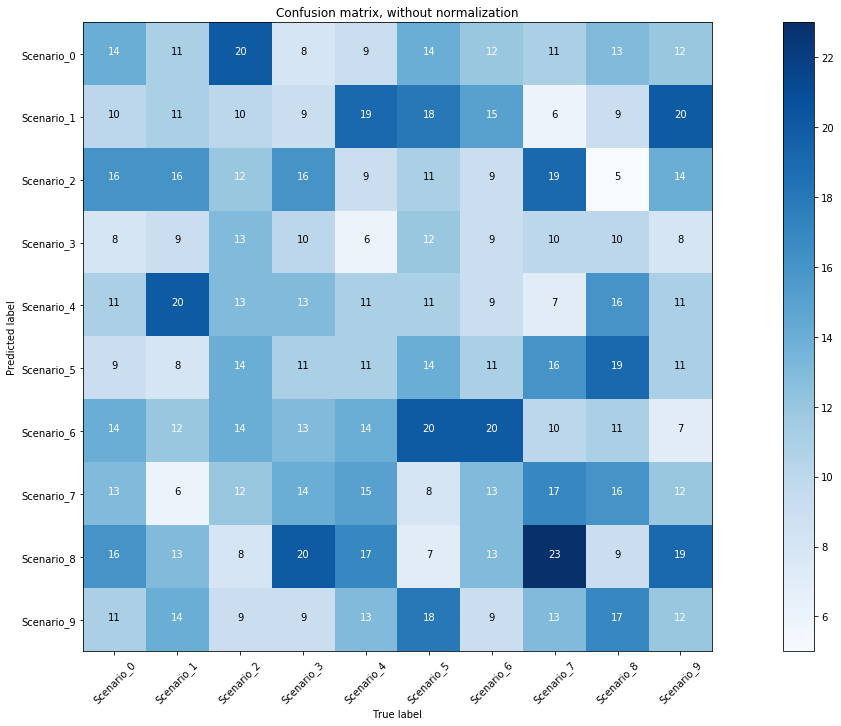

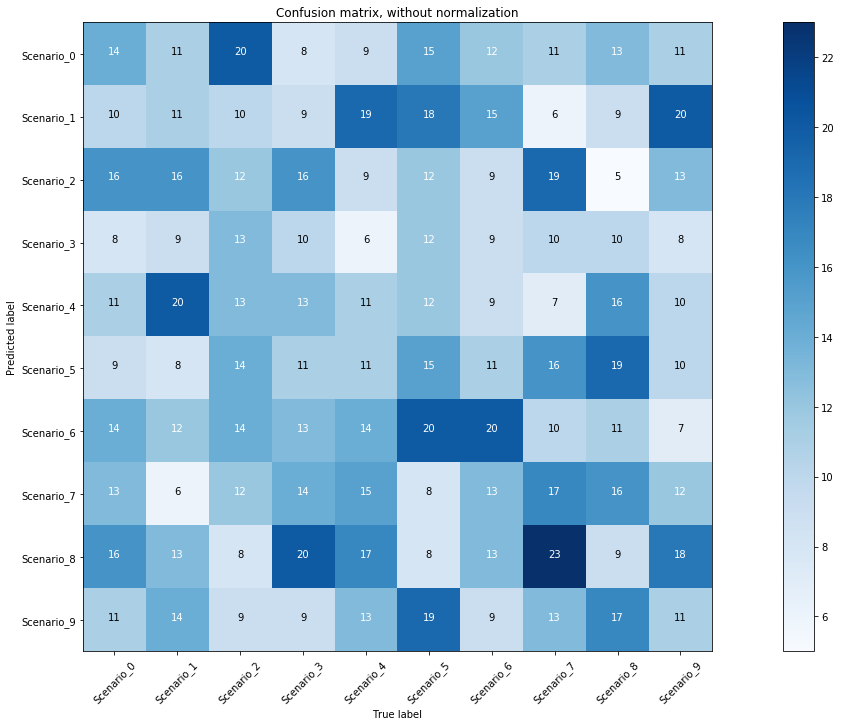

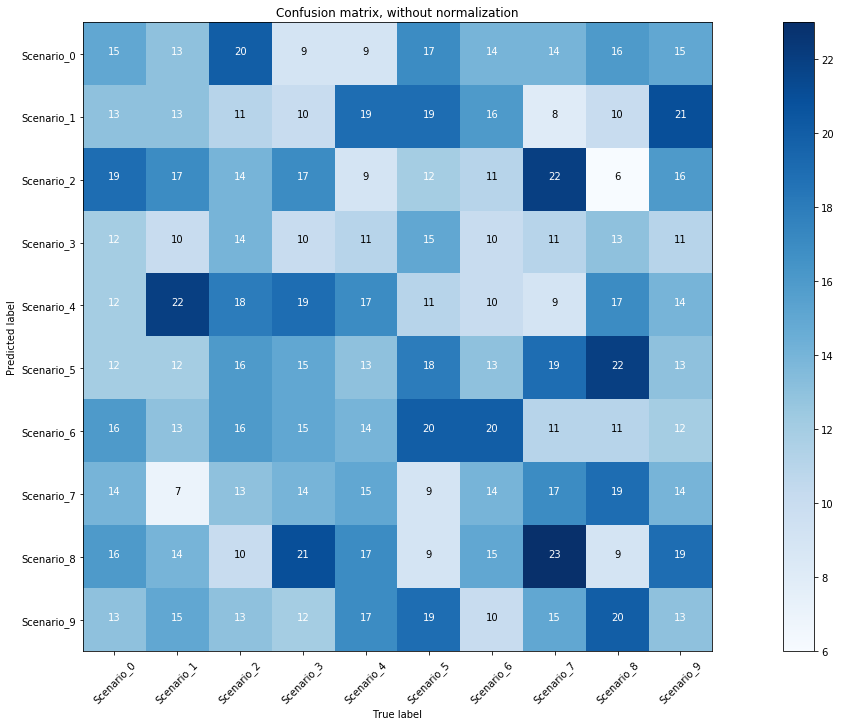

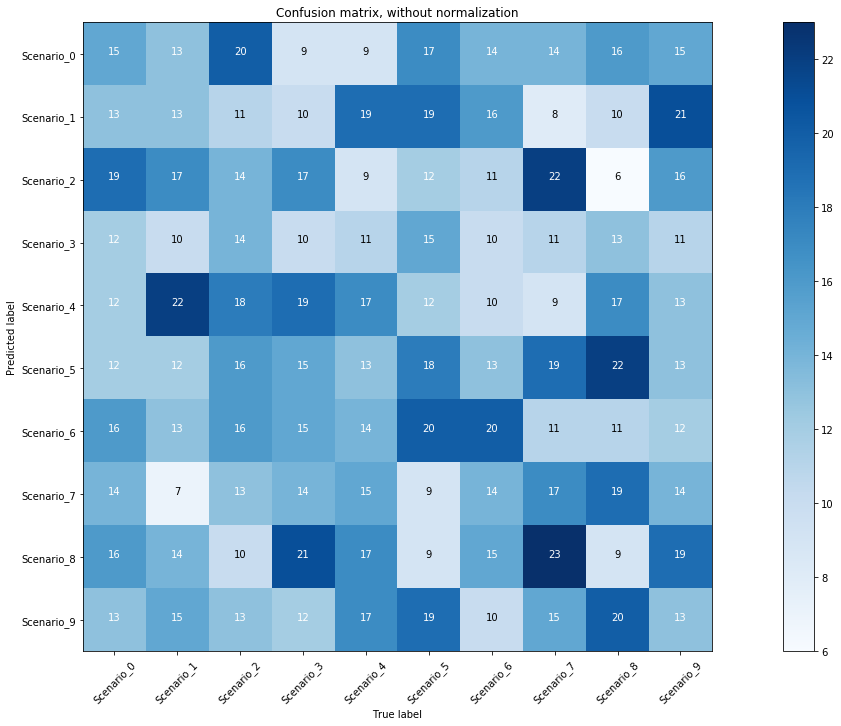

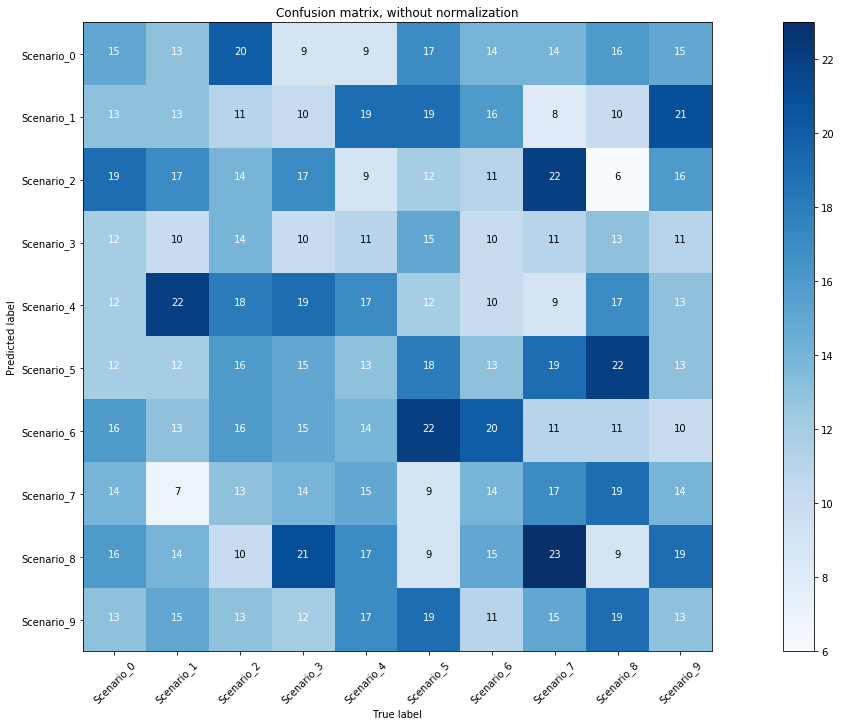

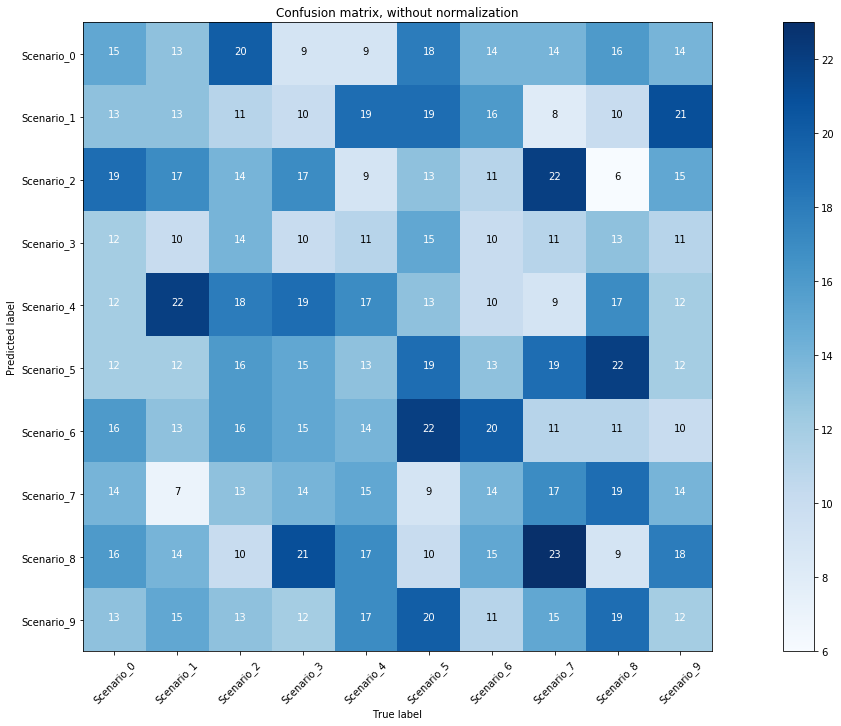

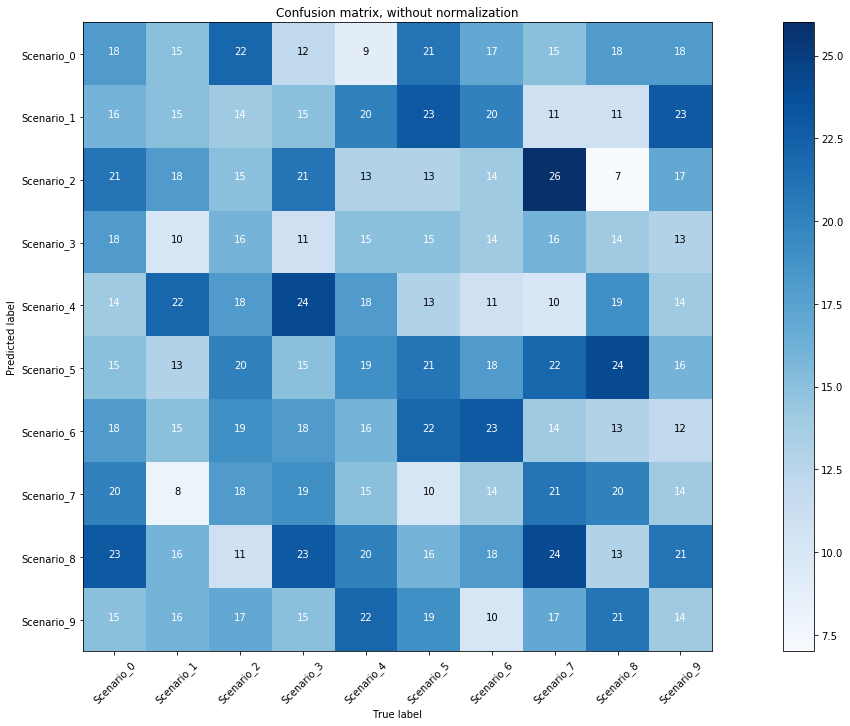

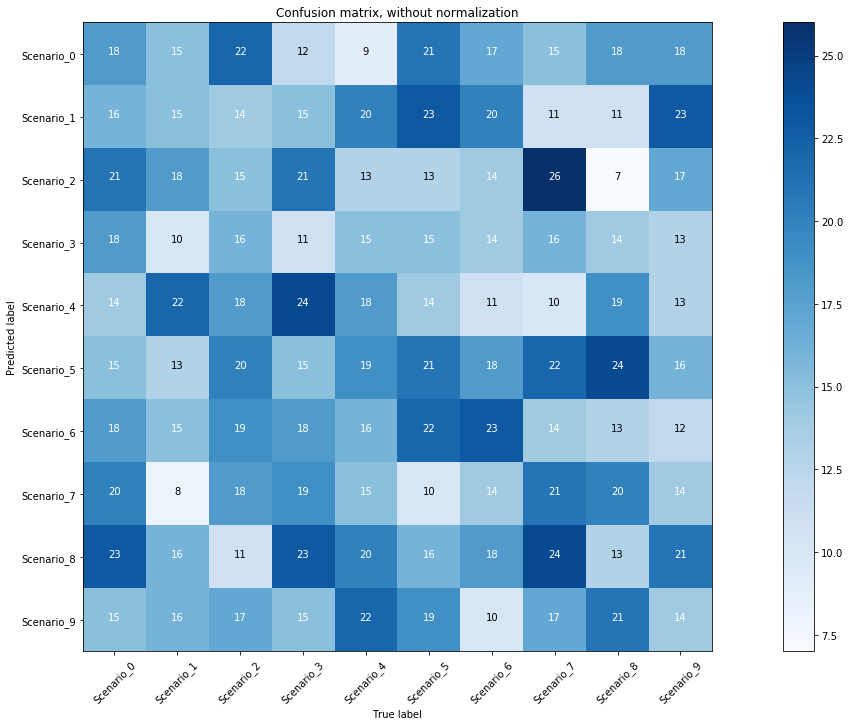

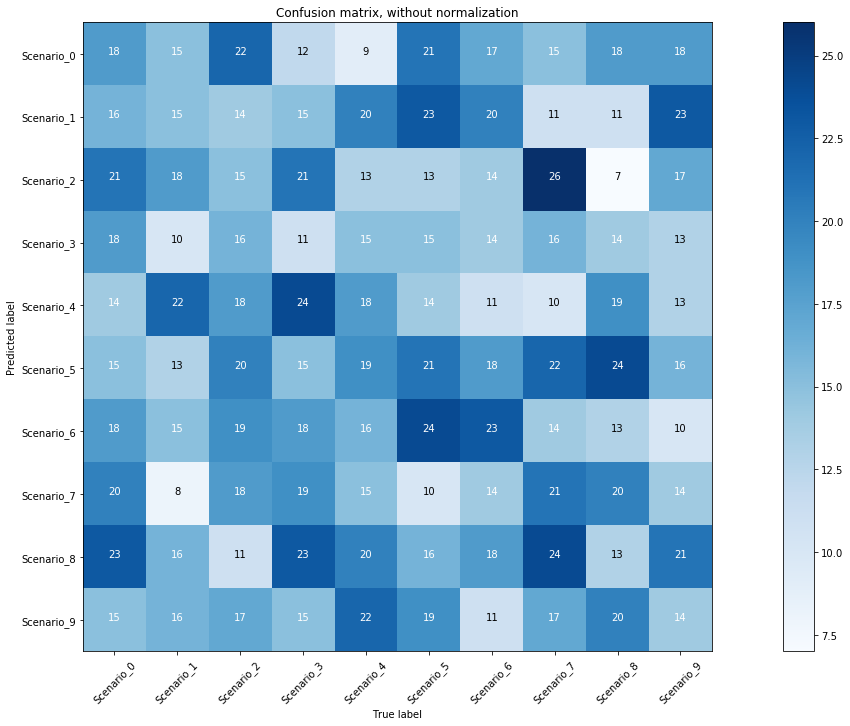

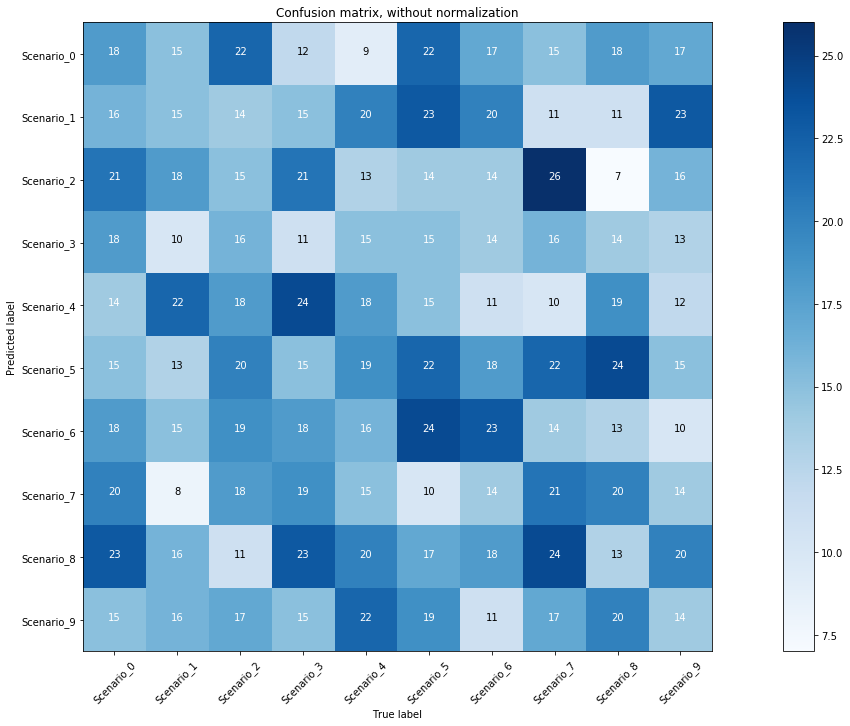

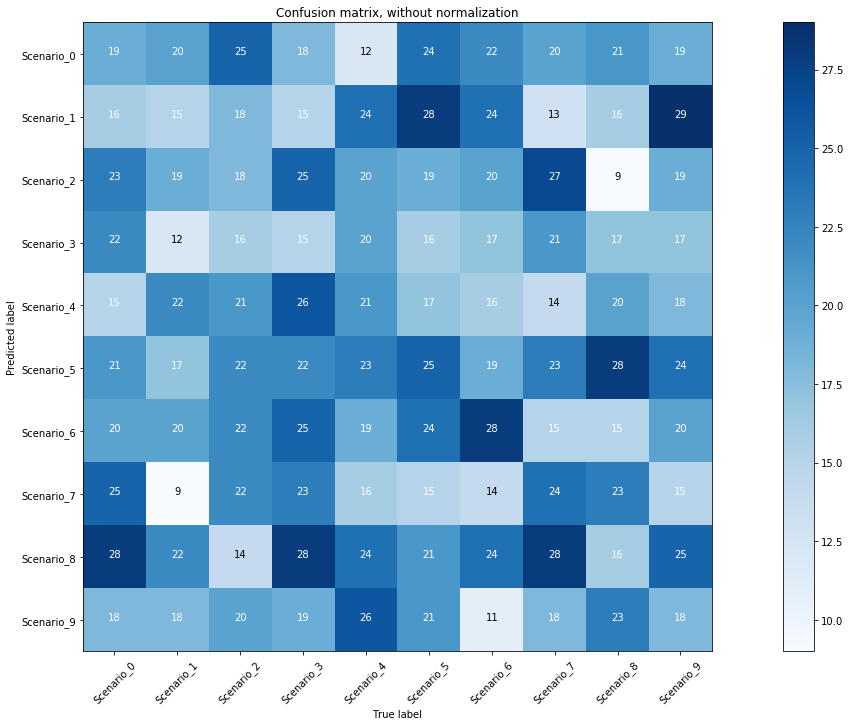

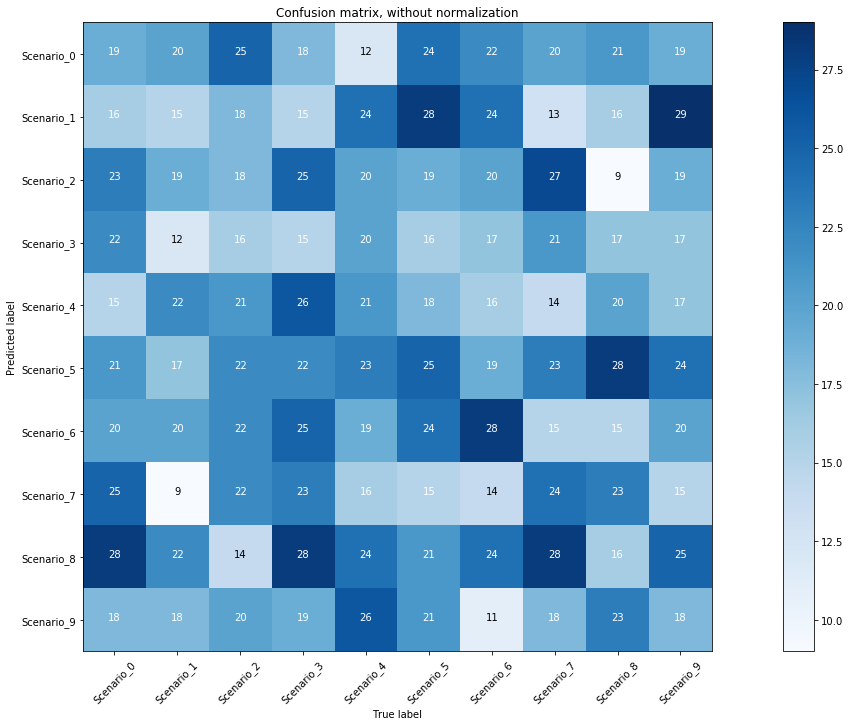

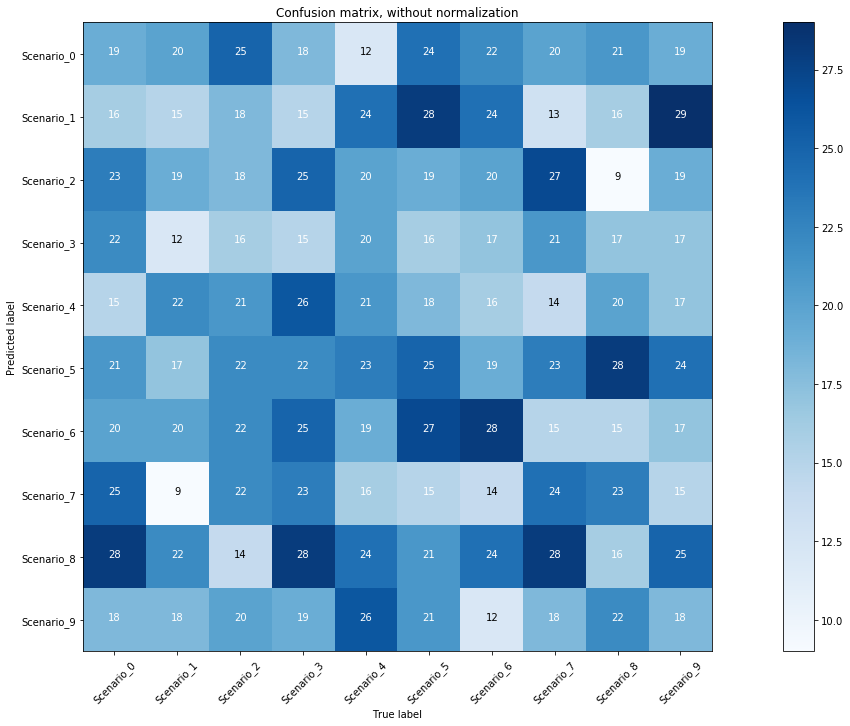

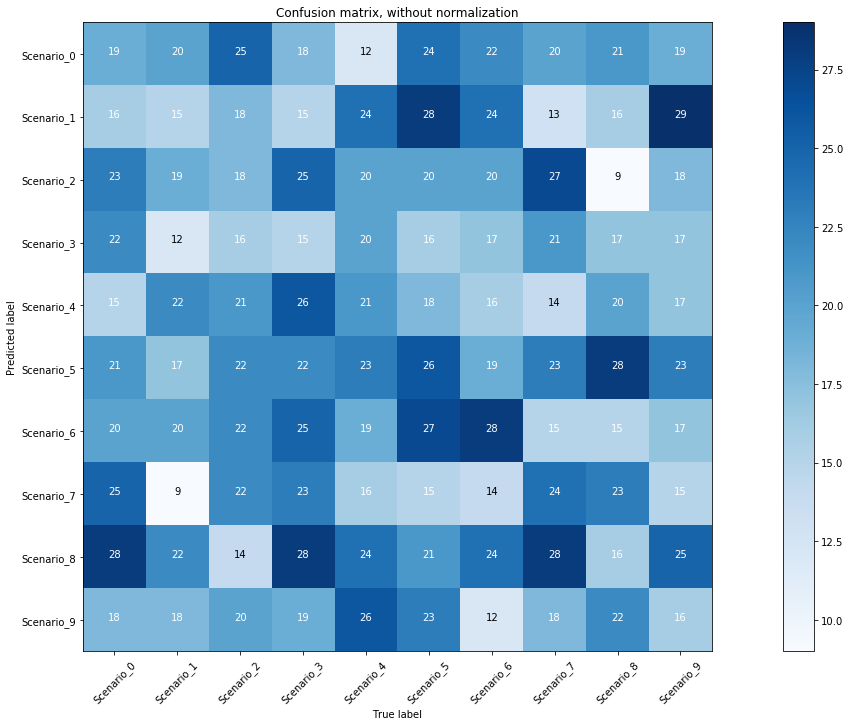

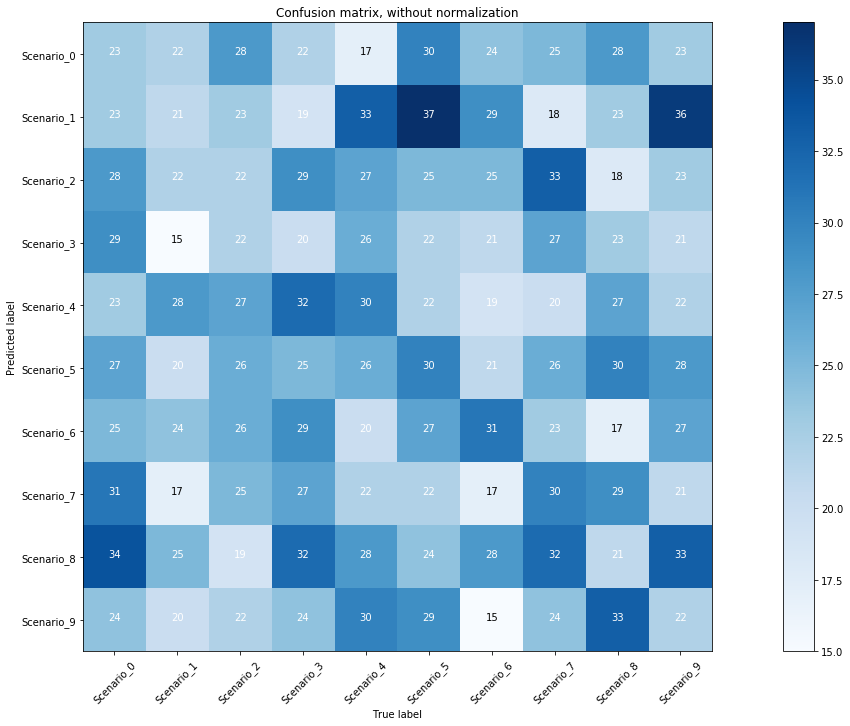

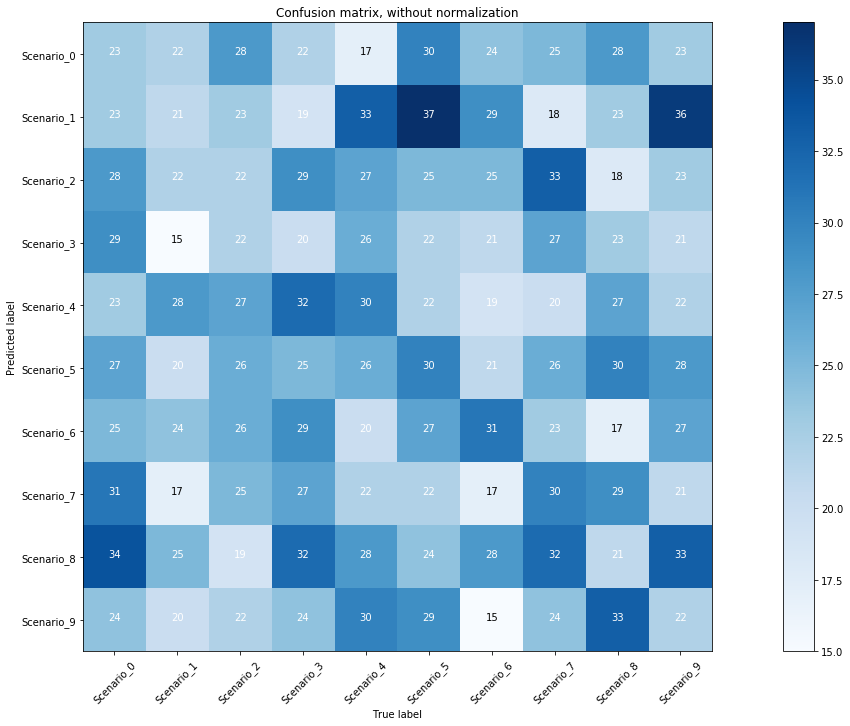

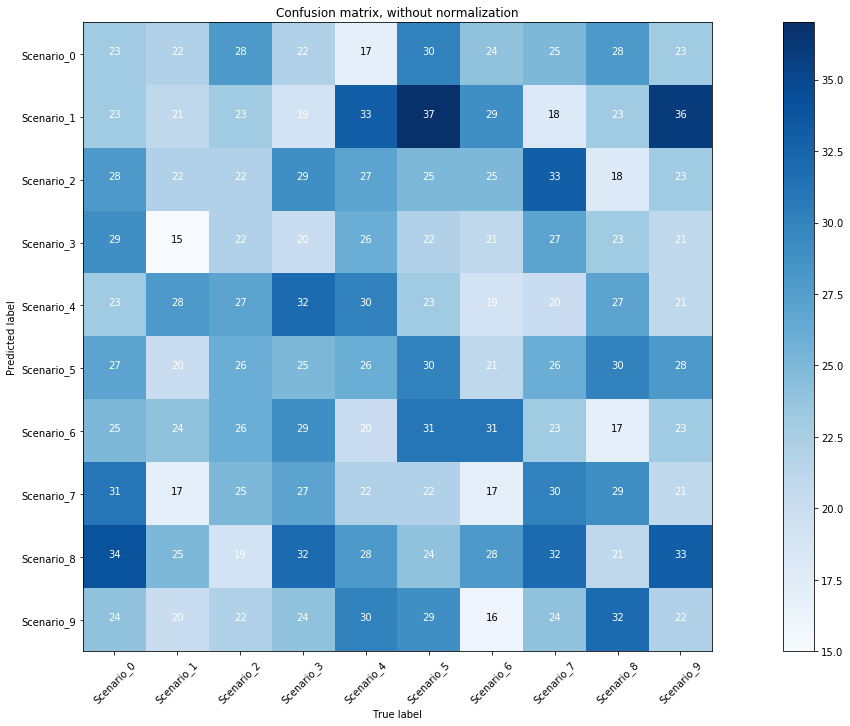

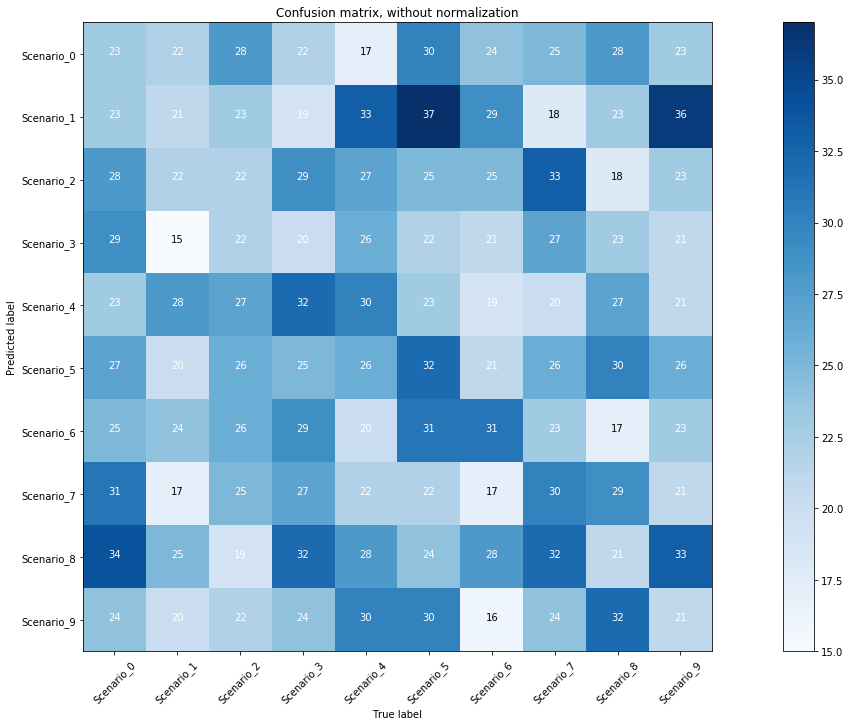

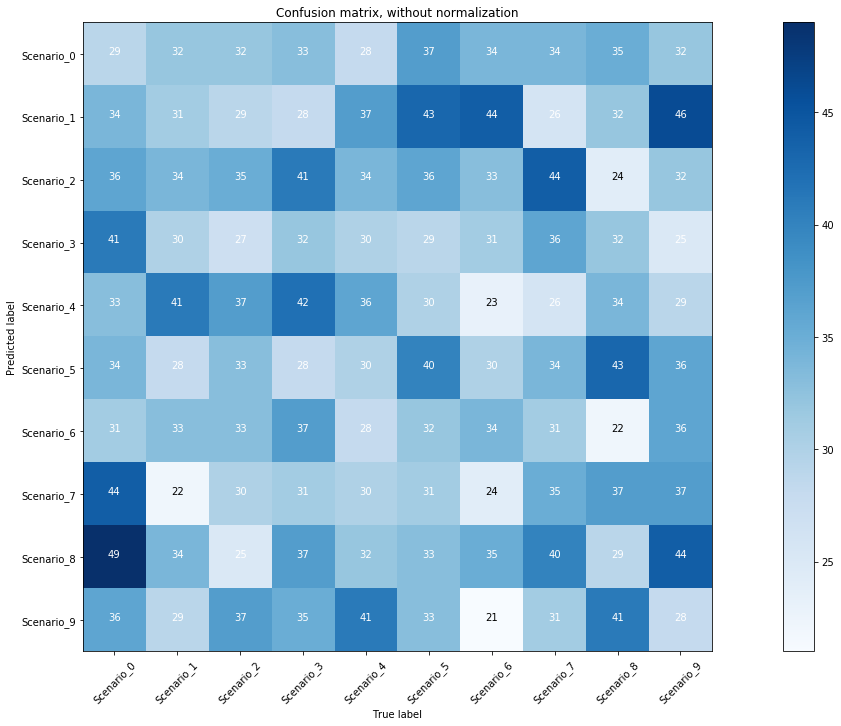

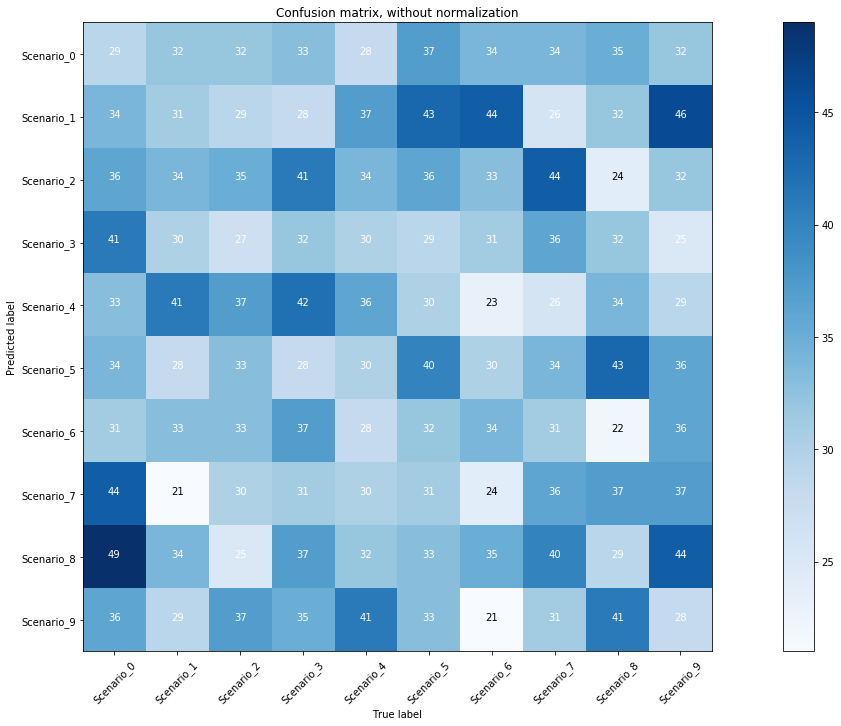

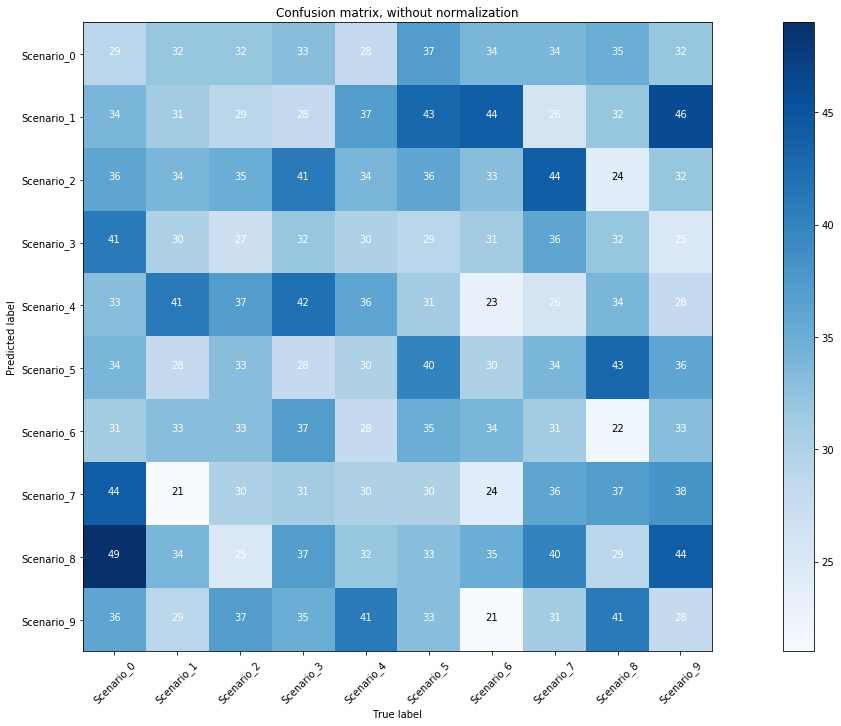

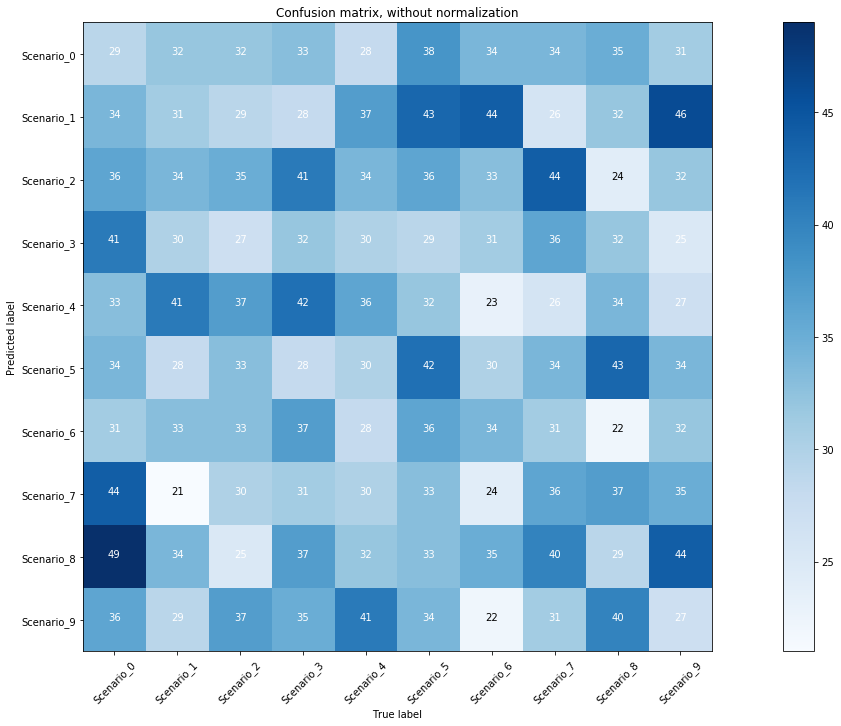

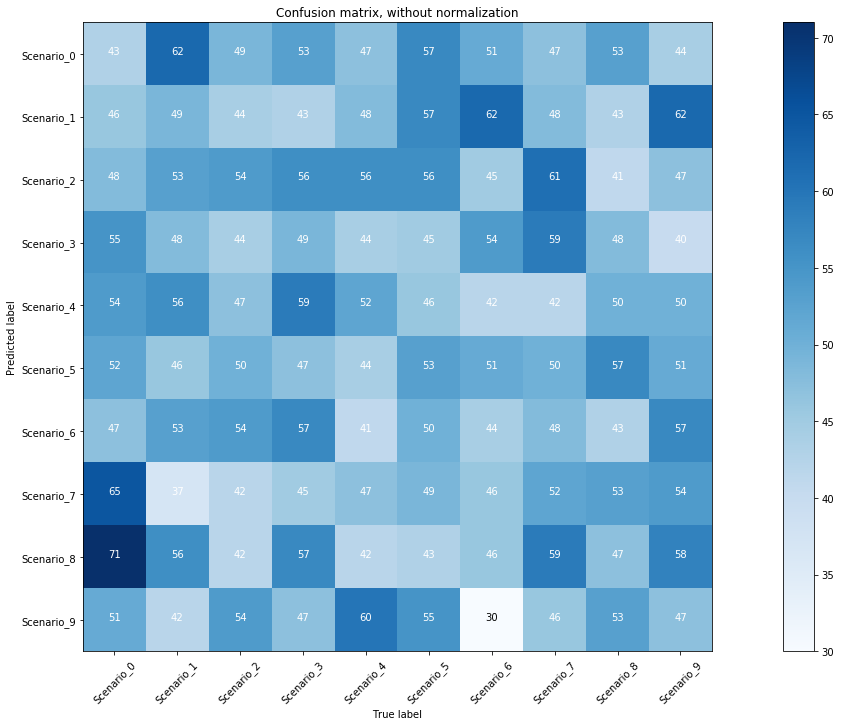

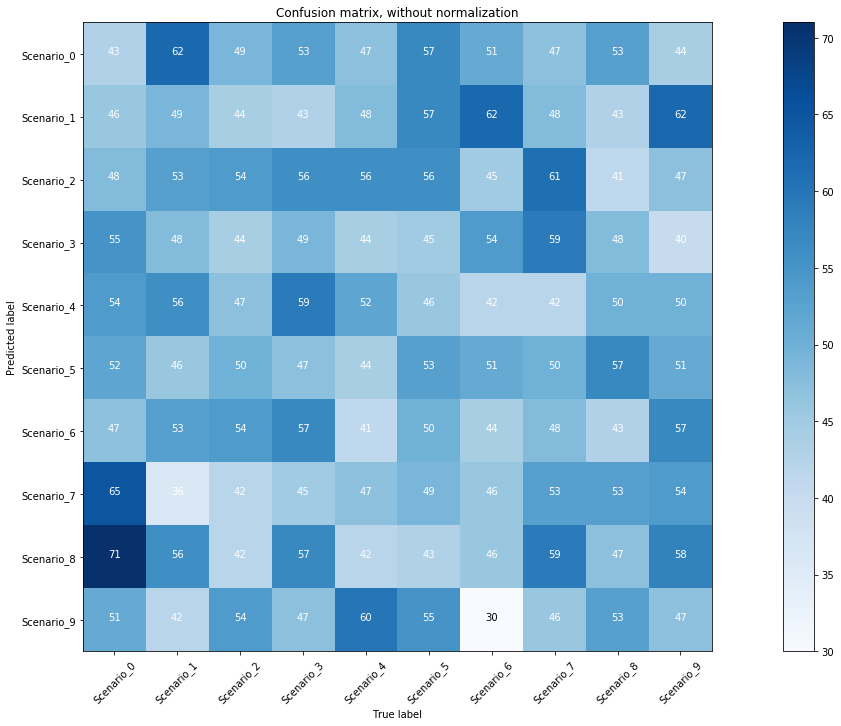

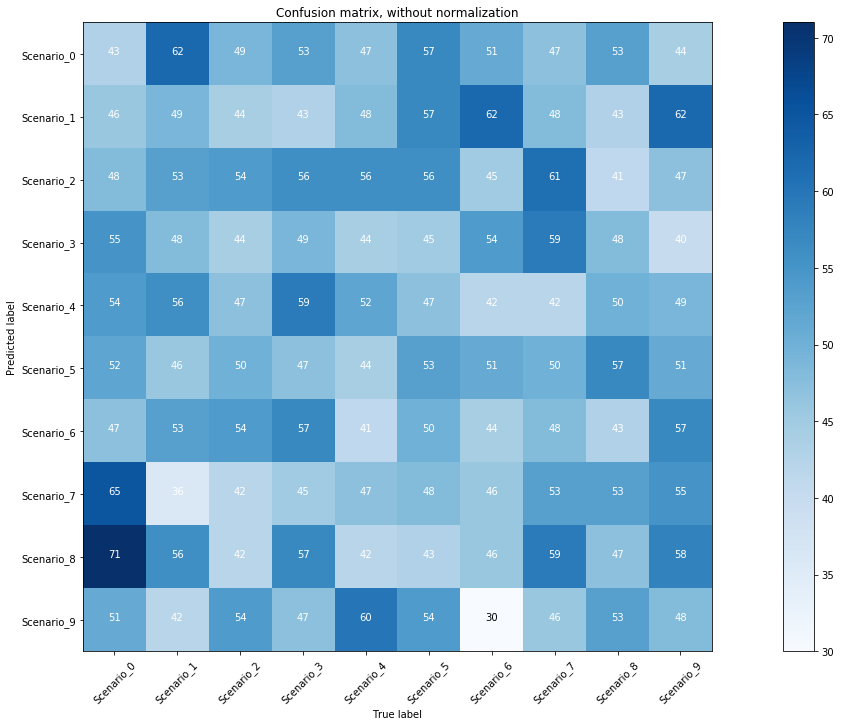

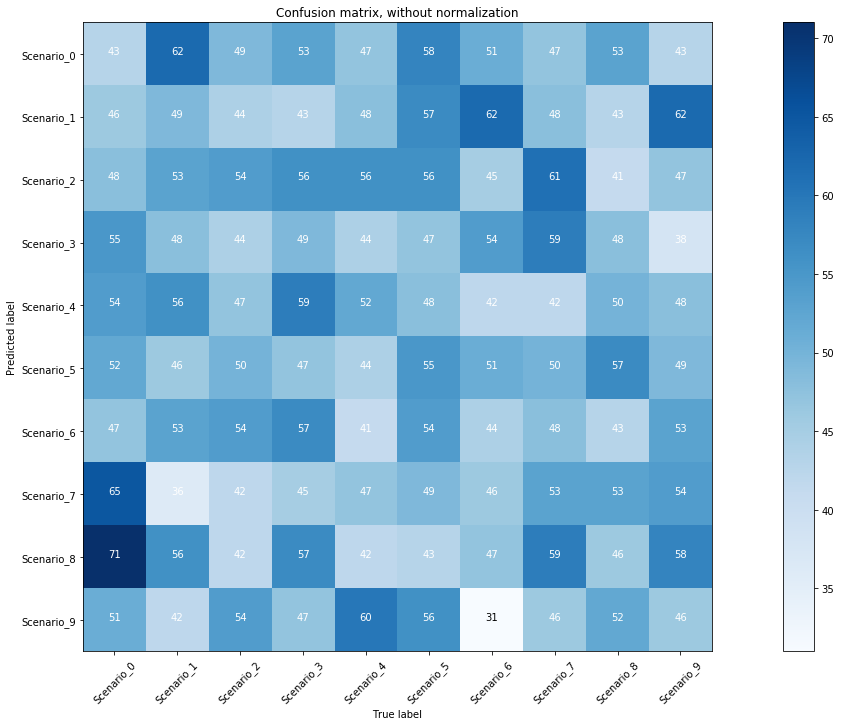

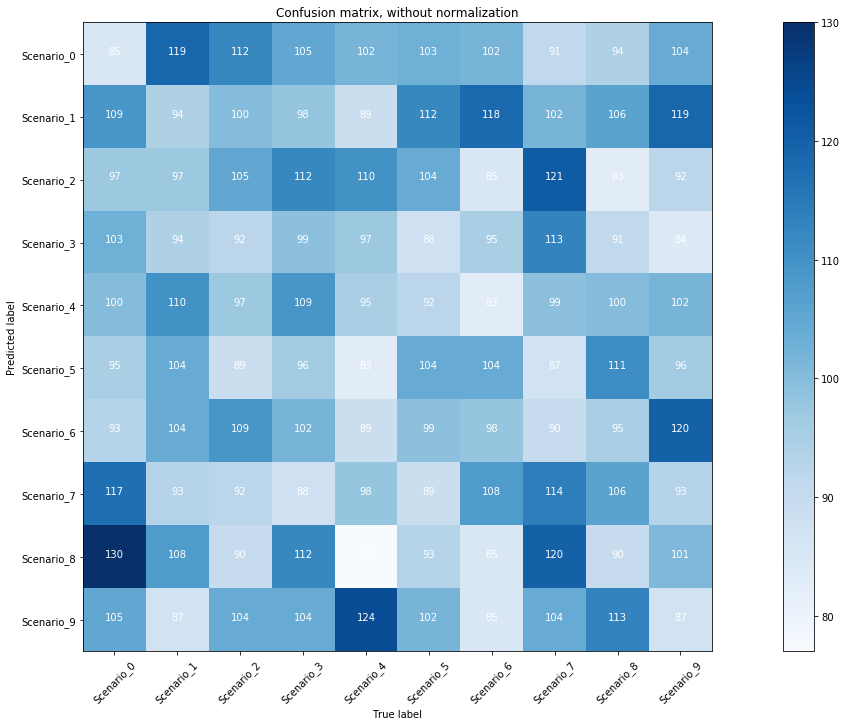

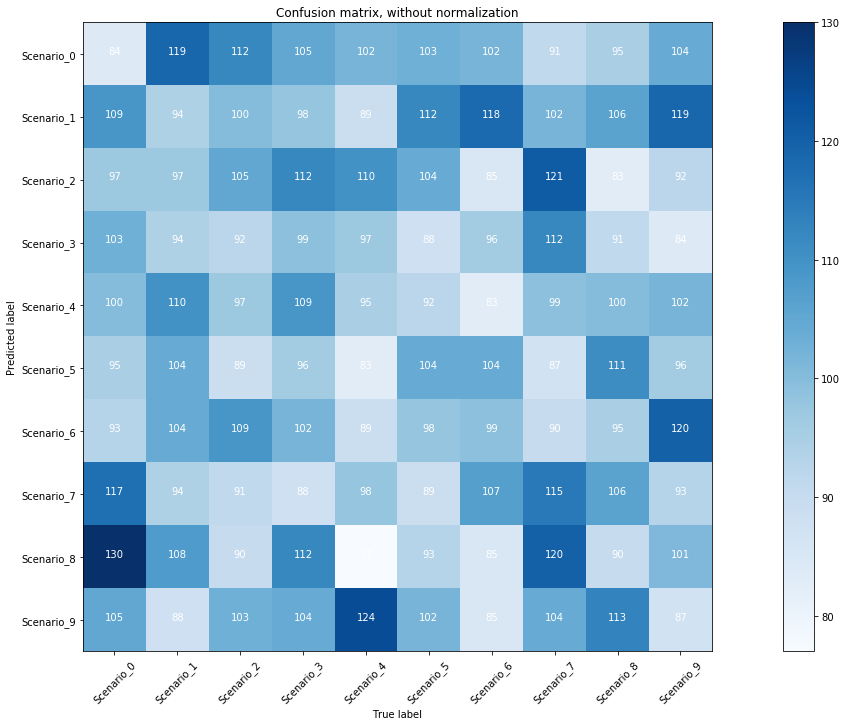

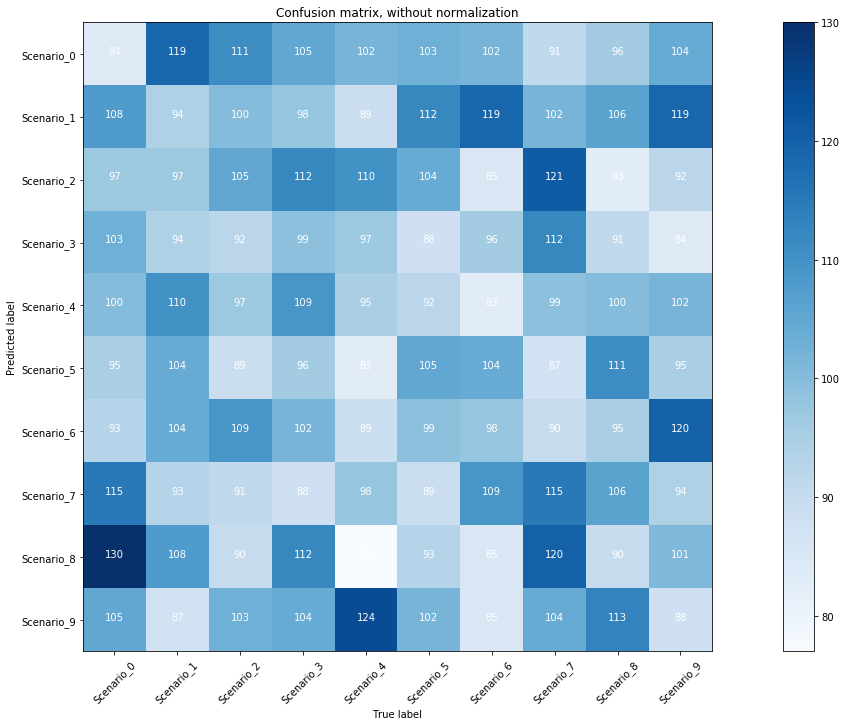

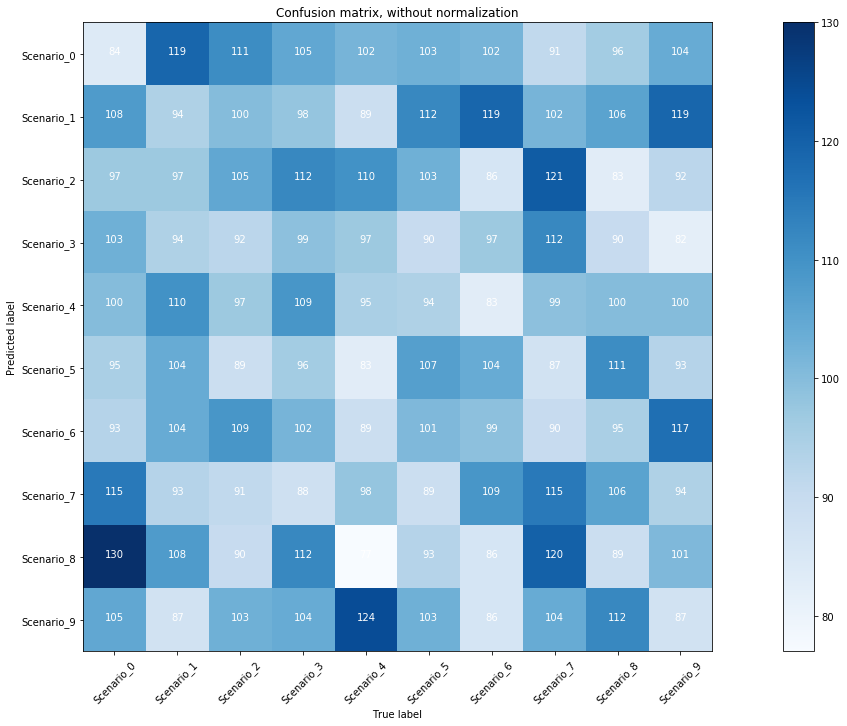

In [15]:
# Compute confusion matrix for knn with variable lenght of data
cnf_matrix_knn = [[] for _ in range(NUM_SLICES)]
for i in range(NUM_SLICES):
    for n in range(len(n_neighbors)):
        cnf_matrix_knn[i].append(confusion_matrix(y_test[i], predictions[i][n]))
        np.set_printoptions(precision=2)

        # Plot non-normalized confusion matrix
        plt.figure(figsize=(20,10))
        plot_confusion_matrix(cnf_matrix_knn[i][n], classes=CLASS_NAMES, verbose=False,
                              title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Training in a loop using SVM
# http://scikit-learn.org/stable/modules/svm.html
from sklearn.svm import SVC
from time import time
svc_list = []
svc_pred = []
svc_accs = []
svc_fit_times = []
svc_pred_times = []
svc_complexities = [1, 10, 100, 1000, 10000, 100000]

for n in range(len(svc_complexities)):
    svc_list.append(SVC(kernel='rbf', C=float(svc_complexities[n])))
    t0 = time()
    svc_list[n].fit(X_train, y_train)
    svc_fit_times.append(round(time() - t0, 3))
    t0 = time()
    svc_pred.append(svc_list[n].predict(X_test))
    svc_pred_times.append(round(time() - t0, 3))
    svc_accs.append(accuracy_score(y_test, svc_pred[n]))
    
print(svc_accs)
print(svc_fit_times)
print(svc_pred_times)

In [ ]:
# Compute confusion matrix for SVM
cnf_matrix_svm = []

for n in range(len(svc_complexities)):
    cnf_matrix_svm.append(confusion_matrix(y_test, svc_pred[n]))
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(20,10))
    plot_confusion_matrix(cnf_matrix_svm[n], classes=CLASS_NAMES, verbose=False,
                          title='Confusion matrix, without normalization for' 
                                 + ' SVM complexity = {}'.format(svc_complexities[n]))

plt.show()


# TODO: http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [ ]:

# TODO: http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [ ]:
### Check the value of feature scaling
# Visualize the data
# First, create a dataframe for knn with the data to train
# Label the columns using the strings in the ml_dataset.feature_names
dataframe = pd.DataFrame(X_train, columns=FEATURE_NAMES)
# create a scatter matrix from the dataframe, color by y_train
grr = pd.plotting.scatter_matrix(dataframe, c=y_train, figsize=(20,20), marker='o',
                                 hist_kwds={'bins': 20}, s=60, alpha=.8)

plt.show()

In [ ]:
# It can be seen that the data is all over the place, so we gonna scale it good

from sklearn import preprocessing
max_abs_scaler = preprocessing.MaxAbsScaler()
X_train_maxabs = max_abs_scaler.fit_transform(X_train)

scaled_dataframe = pd.DataFrame(X_train_maxabs, columns=FEATURE_NAMES)
# create a scatter matrix from the dataframe, color by y_train
grr = pd.plotting.scatter_matrix(scaled_dataframe, c=y_train, figsize=(20,20), marker='o',
                                 hist_kwds={'bins': 20}, s=60, alpha=.8)
plt.show()

In [ ]:
# We check if the confusion matrix or the accuracy changes with
# scaled features

# We start with the knn model

X_test_scaled = max_abs_scaler.transform(X_test)

# Generate the model
knn_scaled = KNeighborsClassifier(n_neighbors=2)
# Train the model
knn_scaled.fit(X_train_maxabs, y_train)
# Make predictions based on the test data
prediction_scaled = knn.predict(X_test_scaled)

In [ ]:
# testing training in a loop
knn_list_scaled = []
predictions_scaled = []
accs_scaled = []
n_neighbors = [2, 4, 10, 50]
for n in range(len(n_neighbors)):
    knn_list_scaled.append(KNeighborsClassifier(n_neighbors=n_neighbors[n]))
    knn_list_scaled[n].fit(X_train_maxabs, y_train)
    predictions_scaled.append(knn_list_scaled[n].predict(X_test_scaled))
    accs_scaled.append(accuracy_score(y_test, predictions_scaled[n]))

print(accs)
print(accs_scaled)

In [ ]:
# Comparing accuracies for svm after scaling


In [ ]:
# Comparing accuracies for svm after scaling
svc_list_scaled = []
svc_pred_scaled = []
svc_accs_scaled = []
svc_fit_times_scaled = []
svc_pred_times_scaled = []
svc_complexities = [1, 10, 100, 1000, 10000, 100000]

for n in range(len(svc_complexities)):
    svc_list_scaled.append(SVC(kernel='rbf', C=float(svc_complexities[n])))
    t0 = time()
    svc_list_scaled[n].fit(X_train_maxabs, y_train)
    svc_fit_times_scaled.append(round(time() - t0, 3))
    t0 = time()
    svc_pred_scaled.append(svc_list_scaled[n].predict(X_test))
    svc_pred_times_scaled.append(round(time() - t0, 3))
    svc_accs_scaled.append(accuracy_score(y_test, svc_pred_scaled[n]))
    
print("Before scaling: ")
print(svc_accs)
print(svc_fit_times)
print(svc_pred_times)
print("After scaling: ")
print(svc_accs_scaled)
print(svc_fit_times_scaled)
print(svc_pred_times_scaled)

In [3]:
import preprocessing
preprocessing.run()

Oh yeah


In [17]:
bla = [[] for _ in range(NUM_SLICES)]
bla

[[], [], [], [], [], [], [], [], [], []]

In [24]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

model = GaussianProcessClassifier(
